# First look on the available data

In [145]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
conn = sqlite3.connect('mock_resq.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('orders',), ('providers',), ('users',), ('master_orders_table',)]

### Orders 

In [112]:
df = pd.read_sql_query(f"SELECT * FROM orders limit 5", conn)
display(df.head())

,id,createdAt,userId,quantity,refunded,currency,sales,providerId
0,4648711062057701806,2023-08-31 10:14:49,833181563296211638,2,0,eur,1000,3518867990385707647
1,1676056141507951956,2023-03-21 17:04:54,7763311846463275691,1,0,eur,400,6413422964860176913
2,7745602867536251060,2023-07-19 09:48:28,8919282109171104948,2,0,eur,680,123356649204044788
3,7319989469562109720,2023-08-10 12:29:01,5785370845306063462,1,0,eur,1099,7268869293921836511
4,8979946097528312402,2022-10-03 09:55:15,8918527236425591239,1,0,eur,200,7530970657789428790


### Users 

In [113]:
df = pd.read_sql_query(f"SELECT * FROM users limit 5", conn)
display(df.head())

,id,country,registeredDate
0,6244948894430711520,FI,2015-11-24 16:31:10
1,7333245412641704133,FI,2015-11-24 16:31:10
2,7387231492403274666,FI,2015-11-24 16:31:10
3,462254365688400616,FI,2015-11-24 16:31:10
4,1895545503734717224,FI,2015-11-24 16:31:10


### Partners 

In [114]:
df = pd.read_sql_query(f"SELECT * FROM providers limit 5", conn)
display(df.head())

,id,defaultOfferType,country,registeredDate
0,6563612899329659014,meal,fin,2015-11-24 16:33:35
1,8724554181611615450,meal,fin,2016-01-27 00:08:50
2,946161542061641905,meal,fin,2016-02-01 15:03:27
3,7056903344430959871,meal,fin,2016-02-02 14:56:40
4,3497712091356119302,meal,fin,2016-02-03 13:20:29


# Sample Data Pipeline

I will first define the schema of the presentation table. After having a quick look on orders, users and providers tables, this could be a suitable schema for the presentation table. 

Order ID - from orders

Order Date - from orders

User ID - from orders

Customer Country - from users

Customer Registration Date - from users

Provider ID - from orders

Provider Country - from providers

Provider Registration Date - from providers

Quantity - from orders

Refunded - from orders

Currency - from orders

Sales - from orders

Default Offer Type (Partner Segment)
This presentation table will allow the analyst to answer questions about sales, partner segments, and customer retention by using simple SELECT queries.

### Query to build presentation table

In [115]:
query = """ CREATE TABLE master_orders_table AS
SELECT 
    o.id AS order_id,
    o.createdAt AS order_date,
    o.userId AS user_id,
    u.country AS user_country,
    u.registeredDate AS user_registration_date,
    o.providerId AS provider_id,
    p.country AS provider_country,
    p.registeredDate AS provider_registration_date,
    p.defaultOfferType AS default_offer_type,
    o.quantity AS order_quantity,
    o.refunded AS order_refunded,
    o.currency AS order_currency,
    o.sales AS order_sales
FROM 
    orders o
INNER JOIN 
    users u ON o.userId = u.id
LEFT JOIN 
    providers p ON o.providerId = p.id; """


In [110]:
#cursor.execute('DROP TABLE IF EXISTS master_orders_table;')
# Commit the transaction to save changes
#conn.commit()

### Creating the master table

In [116]:
cursor.execute(query)
# Commit the transaction to save changes
conn.commit()

#### Selecting sample rows to show the master table

In [117]:
df = pd.read_sql_query(f"SELECT * FROM master_orders_table limit 5", conn)
display(df.head())

,order_id,order_date,user_id,user_country,user_registration_date,provider_id,provider_country,provider_registration_date,default_offer_type,order_quantity,order_refunded,order_currency,order_sales
0,4648711062057701806,2023-08-31 10:14:49,833181563296211638,FI,2019-06-26 13:15:21,3518867990385707647,fin,2022-08-16 06:46:13,meal,2,0,eur,1000
1,1676056141507951956,2023-03-21 17:04:54,7763311846463275691,FI,2020-06-10 16:32:22,6413422964860176913,fin,2020-01-13 12:29:15,meal,1,0,eur,400
2,7745602867536251060,2023-07-19 09:48:28,8919282109171104948,FI,2021-07-08 09:49:25,123356649204044788,fin,2023-05-25 10:25:53,snack,2,0,eur,680
3,7319989469562109720,2023-08-10 12:29:01,5785370845306063462,FI,2020-01-12 16:14:35,7268869293921836511,fin,2022-06-27 12:17:25,meal,1,0,eur,1099
4,8979946097528312402,2022-10-03 09:55:15,8918527236425591239,FI,2018-12-21 14:25:17,7530970657789428790,fin,2019-02-12 08:44:54,snack,1,0,eur,200


# Answering Analysts' Questions
## 1. Query to find the top 10 partners by sales

In [146]:
top_10_partners = """
SELECT 
    provider_id,
    SUM(order_sales) AS totalSales
FROM 
    master_orders_table
GROUP BY 
    provider_id
ORDER BY 
    totalSales DESC
LIMIT 10
"""
df = pd.read_sql_query(f"{top_10_partners}", conn)
display(df)

,provider_id,totalSales
0,7198110370745783236,10917800
1,8312310143652755348,7467750
2,8097235958083241788,2383700
3,3865474760205653333,2223400
4,8084884958338058541,1868140
5,4734853230275691017,1702100
6,5305286819167536850,1690500
7,1066258454353124935,1568100
8,7642201963087705313,1472000
9,4014236829817167297,1457000


<Axes: xlabel='provider_id'>

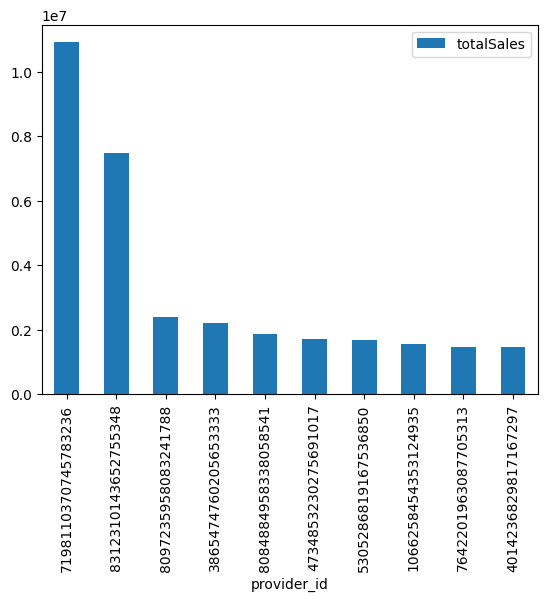

In [148]:
df.plot(kind='bar', x='provider_id', y='totalSales')

## 2. Query to identify the customers’ favourite partner segments (default offer types). Partners are the companies who sell surplus items on the marketplace.

In [149]:
fvt_partner_segments = """
SELECT 
    default_offer_type as partner_segment,
    COUNT(order_id) AS orderCount
FROM 
    master_orders_table
GROUP BY 
    partner_segment
ORDER BY 
    orderCount DESC;
"""
df = pd.read_sql_query(f"{fvt_partner_segments}", conn)
display(df)

,partner_segment,orderCount
0,meal,219764
1,snack,49861
2,grocery-bag,27192
3,dessert,1910
4,ingredients,1091
5,flowers,153


<Axes: xlabel='partner_segment'>

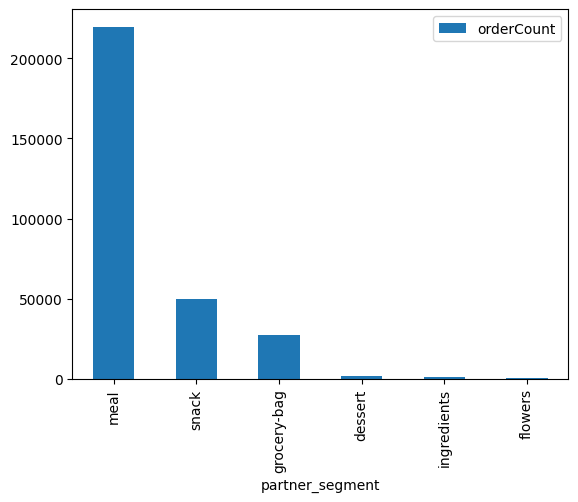

In [150]:
df.plot(kind='bar', x='partner_segment', y='orderCount')

## 3. Query to find out what is the M1 retention for any given customer cohort. A cohort consists of customers who made their first order within the same month (M0). M1 retention is the share of customers who have made at least one purchase one month after their first purchase month.

In [152]:
m1_retention_query = """ 
WITH first_orders AS (
        SELECT user_id,
        strftime('%Y-%m', order_date) AS cohortMonth,  -- Get the first order month
        MIN(order_date) AS firstOrderDate                 -- Get the actual first order date
    FROM 
        master_orders_table
    GROUP BY 
        user_id
    ),
m1_retention AS ( SELECT 
        fo.cohortMonth,
        strftime('%Y-%m',date(fo.firstOrderDate, '+1 month')) AS next_month,
        COUNT(DISTINCT fo.user_id) AS totalCustomers,         -- Total customers in the cohort
        COUNT(DISTINCT m.user_id) AS retainedCustomers         -- Customers who made a purchase in M1
    FROM 
        first_orders fo
    LEFT JOIN 
        master_orders_table m ON fo.user_id = m.user_id 
                             AND strftime('%Y-%m', m.order_date) = 
                                 next_month 
    GROUP BY 
        fo.cohortMonth
)
SELECT 
    cohortMonth,
    next_month,
    totalCustomers,
    retainedCustomers,
    (CAST(retainedCustomers AS FLOAT) / NULLIF(totalCustomers, 0)) * 100 AS m1RetentionRate  -- Calculate retention rate
FROM 
    m1_retention;

"""
df = pd.read_sql_query(f"{m1_retention_query}", conn)
display(df)

,cohortMonth,next_month,totalCustomers,retainedCustomers,m1RetentionRate
0,2022-09,2022-10,4134,1220,29.511369
1,2022-10,2022-11,15292,3393,22.188072
2,2022-11,2022-12,12559,1846,14.698623
3,2022-12,2023-01,8382,1232,14.698163
4,2023-01,2023-02,9153,1440,15.732547
5,2023-02,2023-03,8884,1400,15.758667
6,2023-03,2023-04,9585,1337,13.948878
7,2023-04,2023-05,8276,1139,13.762687
8,2023-05,2023-06,8130,942,11.586716
9,2023-06,2023-07,6698,784,11.704987


<Axes: xlabel='next_month'>

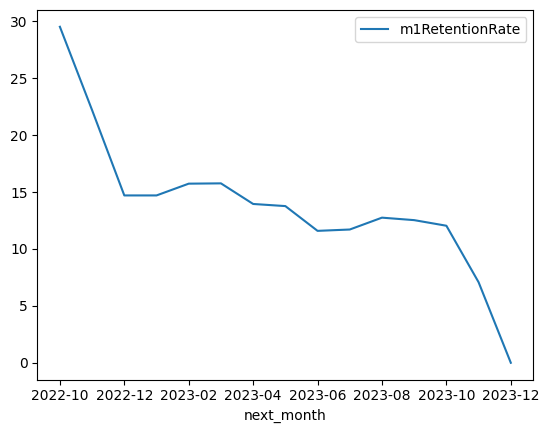

In [153]:
df.plot(x='next_month', y='m1RetentionRate')